**EXAMEN FINAL PREGUNTA 1**

* Dataset:https://drive.google.com/file/d/1ANlgZFq1lauAchmDRPGUaBJAe2G5Q2qK/view?usp=sharing
* repositorio github:https://github.com/R1mber/sis421/tree/master/Examenes/final
* DenseNet creada 2016 ultima actualizacion 2018
densenet121

torchvision.models.densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) → torchvision.*models*.densenet.DenseNet

Densenet-121 model from “Densely Connected Convolutional Networks”. The required minimum input size of the model is 29x29.

***Parametross***
* pretrained (bool) – If True, returns a model pre-trained on ImageNet
* progress (bool) – If True, displays a progress bar of the download to stderr
* memory_efficient (bool) – but slower. Default: False. See “paper”

In [1]:
import os
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import shutil
shutil.copy("/content/drive/MyDrive/inteligencia_artificial/ia2/final/trigo.zip", "trigo.zip")


'trigo.zip'

In [6]:
shutil.unpack_archive("trigo.zip")

In [7]:
path_train = '/content/trigo/train/'
path_test = '/content/trigo/test/'
directorios_train = os.listdir(path_train)
directorios_test = os.listdir(path_test)
directorios_test , directorios_train

(['trigo-duro-con-almidon', 'grano-duro-vitreo'],
 ['trigo-duro-con-almidon', 'grano-duro-vitreo'])

In [8]:
labels_def = {'trigo-duro-con-almidon':0, 'grano-duro-vitreo':1}

In [9]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            images_.append(imgPath2)
            labels_.append(labels_def[d])
    return images_, labels_

def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

In [10]:
imgs , labels = loadImages(path_train,directorios_train)
imgs_test , labels_test = loadImages(path_test,directorios_test)

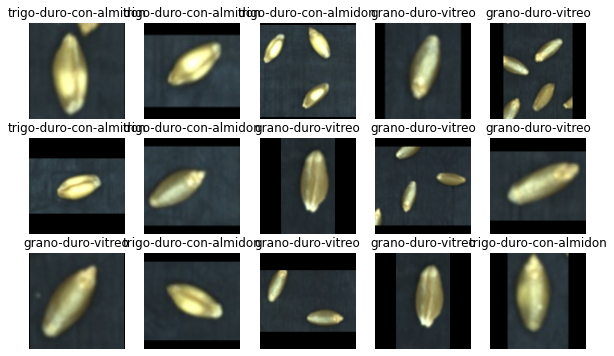

In [11]:

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getText(labels[ix]))
plt.show()

In [12]:
train_imgs = imgs
test_imgs = imgs_test
train_labels = labels
test_labels = labels_test

len(train_imgs), len(test_imgs)

(390, 10)

In [32]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X #torch.from_numpy(X).float().cuda()
        self.Y = Y #torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        img1 = Image.open(self.X[ix])
        new_img = img1.resize((60,60))
        #normalizamos la imagen 
        npImage = np.array(new_img)
        #return self.X[ix], self.Y[ix]
        #img = self.trans(image=img)["image"]
        return torch.from_numpy(npImage / 255.).float().permute(2,0,1), torch.tensor(self.Y[ix])

In [33]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
len(dataset['train']), len(dataset['test']),

(390, 10)

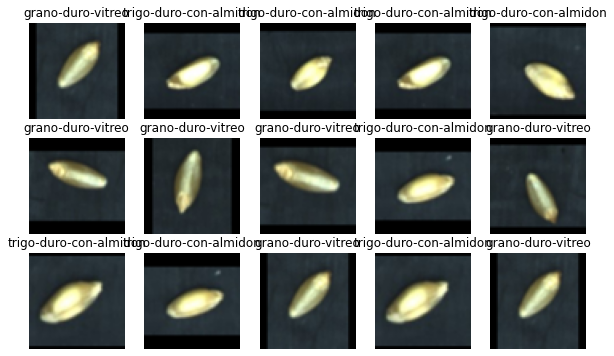

In [34]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))
    #ax.set_title(classes[lab])
plt.show()

In [35]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=65, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=50, shuffle=False)
}

x_train, y_train = next(iter(dataloader['train']))

In [36]:
x_train.shape ,x_train[0].shape

(torch.Size([65, 3, 60, 60]), torch.Size([3, 60, 60]))

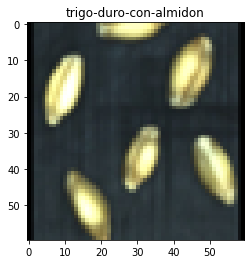

In [37]:
rand = random.randint(0, len(x_train))
img_perm=x_train[rand].permute(1, 2,0)
plt.imshow(img_perm)
plt.title(getText(y_train[rand]))
plt.show()

In [38]:
densenet = torchvision.models.densenet201()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=2, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    densenet = torchvision.models.densenet201(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    #print(self.densenet)
    if freeze:
      for param in self.densenet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1920, 2)
    print(self.fc)
  def forward(self, x):
    x = self.densenet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    
    return x

  def unfreeze(self):
    for param in self.densenet.parameters():
        param.requires_grad=True

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
#torch.cuda.empty_cache()
model = Model()
outputs = model(torch.randn(64, 3, 60, 60))
outputs.shape

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Linear(in_features=1920, out_features=2, bias=True)


torch.Size([64, 2])

In [48]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

**Entrenando desde cero**

In [49]:
model_1 = Model()
fit(model, dataloader, epochs=6)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Linear(in_features=1920, out_features=2, bias=True)


val_loss 0.68805 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch 1/6 loss 0.64118 val_loss 0.68805 acc 0.68718 val_acc 0.50000


val_loss 0.86443 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch 2/6 loss 0.38330 val_loss 0.86443 acc 0.85128 val_acc 0.50000


val_loss 0.96111 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch 3/6 loss 0.27382 val_loss 0.96111 acc 0.90513 val_acc 0.50000


val_loss 1.23496 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch 4/6 loss 0.17164 val_loss 1.23496 acc 0.96410 val_acc 0.50000


val_loss 0.97340 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 5/6 loss 0.10089 val_loss 0.97340 acc 0.97949 val_acc 0.50000


val_loss 0.66614 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

Epoch 6/6 loss 0.07136 val_loss 0.66614 acc 0.98718 val_acc 0.50000


__Transfer Learning__




In [50]:
model_tl = Model(pretrained=True, freeze=True)
fit(model, dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Linear(in_features=1920, out_features=2, bias=True)


val_loss 0.64883 val_acc 0.70000: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch 1/5 loss 0.69895 val_loss 0.64883 acc 0.53590 val_acc 0.70000


val_loss 0.58928 val_acc 0.70000: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch 2/5 loss 0.63784 val_loss 0.58928 acc 0.64359 val_acc 0.70000


val_loss 0.60142 val_acc 0.60000: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 3/5 loss 0.59270 val_loss 0.60142 acc 0.69487 val_acc 0.60000


val_loss 0.61796 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch 4/5 loss 0.55738 val_loss 0.61796 acc 0.75128 val_acc 0.50000


val_loss 0.62390 val_acc 0.60000: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

Epoch 5/5 loss 0.50523 val_loss 0.62390 acc 0.79744 val_acc 0.60000


**fine tunning**

In [53]:
model_ft = Model(pretrained=True, freeze=False)
fit(model, dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=1920, out_features=2, bias=True)


val_loss 0.59321 val_acc 0.70000: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 1/5 loss 0.48192 val_loss 0.59321 acc 0.83077 val_acc 0.70000


val_loss 0.44632 val_acc 0.80000: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 2/5 loss 0.32781 val_loss 0.44632 acc 0.90000 val_acc 0.80000


val_loss 0.13904 val_acc 0.90000: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch 3/5 loss 0.20915 val_loss 0.13904 acc 0.96154 val_acc 0.90000


val_loss 0.11706 val_acc 1.00000: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 4/5 loss 0.13012 val_loss 0.11706 acc 0.97949 val_acc 1.00000


val_loss 0.17898 val_acc 0.90000: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Epoch 5/5 loss 0.08296 val_loss 0.17898 acc 0.98974 val_acc 0.90000


In [52]:
model_modif = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=1920, out_features=2, bias=True)


val_loss 0.68377 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 1/5 loss 0.70840 val_loss 0.68377 acc 0.50513 val_acc 0.50000


val_loss 0.65683 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 2/5 loss 0.61829 val_loss 0.65683 acc 0.68718 val_acc 0.50000


val_loss 0.63090 val_acc 0.50000: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 3/5 loss 0.58324 val_loss 0.63090 acc 0.74615 val_acc 0.50000


val_loss 0.60017 val_acc 0.60000: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 4/5 loss 0.55530 val_loss 0.60017 acc 0.73590 val_acc 0.60000


val_loss 0.61221 val_acc 0.70000: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch 5/5 loss 0.51868 val_loss 0.61221 acc 0.79744 val_acc 0.70000


val_loss 0.59367 val_acc 0.80000: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch 1/5 loss 0.49055 val_loss 0.59367 acc 0.82308 val_acc 0.80000


val_loss 0.52691 val_acc 0.90000: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 2/5 loss 0.49587 val_loss 0.52691 acc 0.79744 val_acc 0.90000


val_loss 0.51607 val_acc 0.90000: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch 3/5 loss 0.48256 val_loss 0.51607 acc 0.83333 val_acc 0.90000


val_loss 0.53356 val_acc 0.70000: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 4/5 loss 0.48105 val_loss 0.53356 acc 0.84359 val_acc 0.70000


val_loss 0.51275 val_acc 0.80000: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Epoch 5/5 loss 0.47220 val_loss 0.51275 acc 0.84872 val_acc 0.80000


In [62]:
torch.save(model_ft.state_dict(), 'saved_weights_ft.pt')
path = 'saved_weights_ft.pt'


In [63]:
model_ft.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
image_al = Image.open('almidon.jpg')
new_img_alm = image_al.resize((60,60))
npImage_1 = np.array(new_img_alm)

image_vit = Image.open('/content/vitreo.jpg')
new_img_vit = image_al.resize((60,60))
npImage_2 = np.array(new_img_alm)

imagen_01 =  torch.from_numpy(npImage_1 / 255.).float().permute(2,0,1)
imagen_02 =  torch.from_numpy(npImage_2 / 255.).float().permute(2,0,1)

In [67]:
model_ft.eval()
with torch.no_grad():
    output = model(imagen_01.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
pred_mask

tensor(0)

In [69]:
model_ft.eval()
with torch.no_grad():
    output1 = model(imagen_02.unsqueeze(0).to(device))[0]
    pred_2 = torch.argmax(output1, axis=0)
pred_2

tensor(0)